# Simulation et Monte-Carlo: Modèle d'Ising avec bruit

In [19]:
from PIL import Image, ImageOps
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import measureError

## 0. Présentation du sujet

### 0.1 Cadre du sujet

On s'intéresse à une méthode de débruitement d'image, en considérant un modèle de débruitage de la forme $y_i | x_i = k \sim \mathcal{N}(\mu_k, \tau^2)$, où $y_i$ représente le niveau de gris du pixel considéré.

On considère que les $x_i$, à valeur dans $\lbrace 0, 1 \rbrace$ suivent une loi d'Ising: $p(x) = \frac{1}{Z(\alpha, \beta)} exp \lbrace \alpha \sum \limits_{i} x_i + \beta \sum \limits_{i \sim j} 1 \lbrace x_i = x_j \rbrace \rbrace.$

La deuxième somme ici porte sur les paires de pixels voisins, et $Z(\alpha, \beta)$ est une constante de normalisation.

L'idée est que les pixels se comportent de manière similaires à leurs voisins: si un pixel d'une couleur a majoritairement des pixels d'une autre couleur, alors il est probable que ce pixel soit une anomalie.


### 0.2 Réponse théorique

On dispose donc de trois hyperparamètres qui permettent de débruiter l'image, les $(\mu_k)$ étant considérés constants: $\alpha, \beta$ et $\tau$.

Au cours du projet, nous nous affranchirons au fur et à mesure des différents hyperparamètres: en question 1., les trois hyperparamètres sont fixés, en question 2., $\tau$ est considéré inconnue, puis en question 3., les trois hyperparamètres sont supposés inconnus.

En pratique, on considère (faire résumé rapide des idées derrière les raisonnements théoriques).

### 0.3 L'image

Au cours du projet, nous utiliserons l'image suivante: [https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/op-art-black-and-white-infinity-whirl-tom-hill.jpg].

Cette image a l'avantage d'être en noir et blanc, donc il n'y a pas de raisonnement à avoir sur les pixels de couleurs différents. Tous les pixels de l'image seront binaires, et vaudront soit $0$ ou $255$.

On charge l'image à partir du module PIL de Python

None
(237, 270)
L


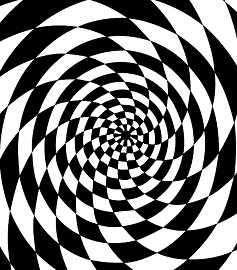

In [20]:
image = Image.open('op-art-black-and-white-infinity-whirl-tom-hill.jpg') #chargement de l'image
#image = Image.open('ok_gibbs.jpg')
image = ImageOps.grayscale(image) #passage de l'image en noir et blanc
print(image.format)
print(image.size)
length = image.size[0]
height = image.size[1]
print(image.mode)
# afficher l'image
data = np.asarray(image) #passage des valeurs des pixels de l'image en tableau numpy
image

### 0.4 Bruiter l'image

Pour bruiter l'image, nous passons sur chaque pixel, et changeons sa couleur avec une probabilité de $0.1$.

Le code pour bruiter une image est le suivant:

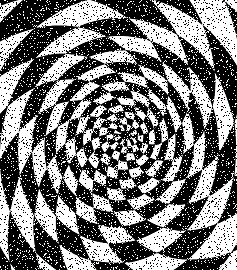

In [21]:
def bruiteur(image, proba):
  image_array = data.astype('int16')
  image_array = image_array
  # Pour chaque pixel, on inverse sa couleur avec proba 10 %
  for i in range(np.shape(image_array)[0]):
    for j in range(np.shape(image_array)[1]):
      a = np.random.choice([-1, 1], None, p=[proba, 1-proba])
      if a < 0:
        image_array[i][j] = 255 - image_array[i][j]
  return image_array
bruit_test = bruiteur(image, 0.1) # Bruitage par inversion de 10 % des pixels

PIL_image = Image.fromarray(np.uint8(bruit_test)).convert('L')
PIL_image

Une fois l'image bruitée et ses pixels enregistrés, on renormalise la matrice contenant les pixels

In [22]:
bruit_test_norm = 2*(bruit_test/255)-1 # yi € {-1 ; 1} (image bruitée, 1 = noir, -1 = blanc), xi € {-1 ; 1} (image restaurée, 1 = noir, -1 = blanc)

### 0.5 La mesure de l'erreur

Pour mesurer l'erreur commise lors du débruitage de l'image, on a deux possibilités à priori: mesurer l'erreur totale, c'est-à-dire le nombre de pixels qui n'ont pas la bonne couleur sur l'image débruitée par rapport à l'image réelle., ou compter le nombre de pixels qui ont un véritable impact sur la qualité de l'image.

La première approche n'est pas forcément idéale, à cause des problèmes au niveau des zones frontières: au moment du débruitage, des pixels sur les zones frontalières peuvent apparaitre. C'est une erreur per se, mais elle n'est pas vraiment détectable à l'oeil nu, et n'a donc pas d'impact réel sur la qualité de l'image débruité.

Pour résoudre ce problème, la deuxième approche consiste à comparer un pixel faux à priori avec ses voisins. Si un certain nombre de voisins ont la même couleur, on peut conclure que le pixel faux se situe au niveau d'une zone frontalière, et n'a donc que peu d'impact sur la qualité observée de l'image.

Les fonctions de mesure de l'erreur sont implémentées dans le fichier `measureError.py`, importé comme module ici.

## 1. Sampler de Gibbs avec $\tau$, $\alpha$ $\beta$ connus

On suppose ici connaitre $\tau$, $\alpha$ et $\beta$. On code alors un echantilloneur de Gibbs pour sampler selon $x_i|y_i$

Pour coder ce sampler, nous avons utilisé deux sites: [https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153] et [https://pchanda.github.io/IsingModelDenoising/]

On commence par fixer les constantes

In [23]:
tau = 1.02 # écart-type de yi|xi=k
alpha = 0 # paramètre devant somme xi dans la loi d'Ising
beta = 0.4 # paramètre devant nombre de voisins de même couleur dans la loi d'Ising

## 1.1 Débruiteur

In [24]:
# Sampler de Gibbs (tau, alpha, beta connus)
# https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153
# https://pchanda.github.io/IsingModelDenoising/

def debruiteur(img_bruitee, samples, alpha, beta, tau):
  probas = np.zeros(bruit_test_norm.shape)
  img_random = 2*np.random.randint(2, size=(height, length))-1
  for step in range(samples):
          for i in range(1, img_random.shape[0]-1):
              for j in range(1, img_random.shape[1]-1):
                  y = sample_y(i, j, img_random, img_bruitee, alpha, beta, tau)
                  img_random[i, j] = y
                  if y == 1:
                      probas[i, j] += 1
  probas = probas / samples
  return probas

def sample_y(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1
  
probas = debruiteur(bruit_test_norm, 20, alpha, beta, tau)

## 1.2 Affichage de l'image débruitée

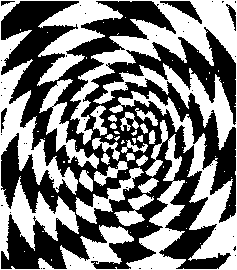

In [25]:
probas_copy = ((probas <= 0.5).astype(int))*255
PIL_image2 = Image.fromarray(np.uint8(probas_copy)).convert('L')
PIL_image2

## 1.3 Mesure de l'erreur

In [26]:
#Erreur totale de l'image initiale bruitée:
measureError.totalError(PIL_image, image)

6540

In [27]:
#Erreur totale de l'image débruitée
measureError.totalError(PIL_image2, image)

26429

On a plus d'erreurs au total dans l'image débruitée que dans l'image initiale. Pourtant l'image ressemble plus à l'originale que l'image bruitée. Ce n'est pas une bonne métrique.

On regarde donc les erreur de qualité des deux images

In [28]:
#Erreur avec impact sur la qualité de l'image pour l'image bruitée:
measureError.qualityError(PIL_image, image, neighbourThreshold = 3)

6400

In [29]:
#Erreur avec impact sur la qualité de l'image pour l'image débruitée:
measureError.qualityError(PIL_image2, image, neighbourThreshold = 3)

862

Le débruitage a donc un impact: si on ne prend que les pixels qui sont très différents de leurs voisins, il y a beaucoup moins d'erreurs que pour l'image bruitée

## 2 $\tau$ inconnu

On suppose que $\tau$ une loi a priori en Inverse-Gamma

On va appliquer un algorithme de Metropolis-Hastings à chaque itération pour déterminer $\tau$, puis se ramener au cas de la question 1.

On peut définir les valeurs de $\alpha$, $\beta$ et les paramètres de la loi Inverse-Gamma, noté $\gamma_{inv9$ et $\rho_{inv}$.

In [30]:
alpha_ising = 0
beta_ising = 0.3
gamma_inv = 3
rho_inv = 0.5

## 2.1 Sampler 

On commence par définir le sampler qu'on utilisera pour cette question

In [31]:
def sample_y_Q2(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1

## 2.2 Metropolis-Hastings pour sampler $\tau$

Comme $\tau$ est inconnu dans cette question, on utilise l'algorithme de Metropolis-Hastings pour le déterminer.

Pixel par pixel, on sample un $\tau$, puis, à partir du $\tau$ déterminé, on effectue une étape en utilisant le $\tau$ moyen des $\tau$ déterminés par sampling à l'étape précédente.

In [32]:
def metropolis_hastings(target_density, a, b, tau_precedent, size=1):
    burnin_size = 0
    size += burnin_size
    x0 = tau_precedent
    xt = x0
    samples = []
    for i in range(size):
        xt_candidate = np.random.normal(xt, 0.15)
        accept_prob = min((target_density(xt_candidate))/(target_density(xt)), 1)
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    return samples[0]

## 2.3 Débruitage de l'image

tau estimé : 1.4802138828232698
Erreur par debruitage  920


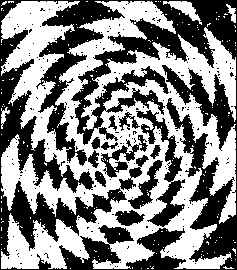

tau estimé : 1.4611679601100522
Erreur par debruitage  866


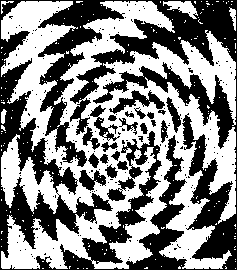

tau estimé : 1.4421169133617948
Erreur par debruitage  739


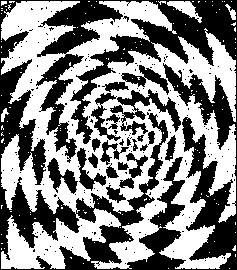

tau estimé : 1.4250306742400778
Erreur par debruitage  752


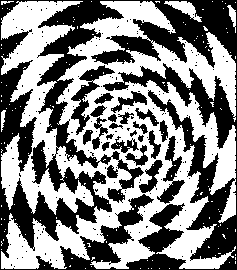

tau estimé : 1.4061345128800544
Erreur par debruitage  688


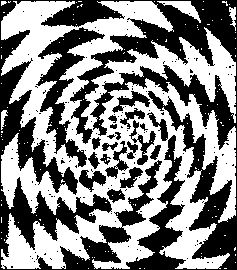

tau estimé : 1.388249586597388
Erreur par debruitage  716


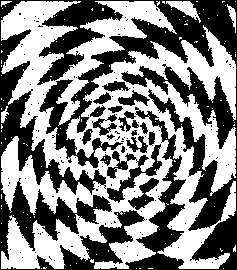

KeyboardInterrupt: 

In [36]:
def debruiteur_Q2(img_bruitee, alpha_ising, beta_ising, gamma_inv, rho_inv, nbre_tirages):
  img_random = 2*np.random.randint(2, size=(height, length))-1
  a,b = img_random.shape
  sim_tau = [1.5*np.ones((height, length)) for i in range(nbre_tirages)]
  somme_voisins = 0
  samplez = 35
  probas = np.zeros((height, length))
  for step in range(1, nbre_tirages):
    mean_step=np.mean(sim_tau[step-1])
    for s in range(samplez):
      for k in range(1, img_random.shape[0]-1):
        for l in range(1, img_random.shape[1]-1):
          y = sample_y_Q2(k, l, img_random, img_bruitee, alpha_ising, beta_ising, mean_step)
          img_random[k, l] = y
          if y == 1:
            probas[k,l] += 1
          markov_blanket = [img_random[k - 1, l], img_random[k, l - 1], img_random[k, l + 1], img_random[k + 1, l], img_bruitee[k, l]]
          somme_voisins = 0
          for g in range(len(markov_blanket)):
            if (img_random[k,l] == markov_blanket[g]):
              somme_voisins+=1
          fct_actuelle = lambda tau: 1/(tau**(gamma_inv+2))*math.exp(-1/(2*tau**2)*((img_random[k,l] - img_bruitee[k,l])**2) + beta_ising*somme_voisins - rho_inv/tau)
          sim_tau[step][k, l] = metropolis_hastings(fct_actuelle, a, b, sim_tau[step-1][k, l], size=1)
    img_random = 2*(probas/samplez >= 0.5) - 1 # Matrice des y déterminés par Gibbs
    probas = np.zeros((height, length)) # Reset de la matrice probas (sinon l'image disparaît petit à petit)
    sim_tau[step] = np.mean(sim_tau[step])*np.ones((height,length))
    print("tau estimé :", np.mean(sim_tau[step]))
    img_random[img_random == 1] = 255
    img_random[img_random == -1] = 0
    img_random = np.array(img_random, dtype=np.int64) # image débruitée après l'étape step
    print("Erreur par debruitage ", measureError.qualityError(img_random, data, neighbourThreshold = 3)) # affiche l'erreur pertienent commise lors des différentes étapes de débruitage
    PIL_image2 = Image.fromarray(np.uint8(img_random)).convert('L')
    display(PIL_image2)
    img_random = 2*np.random.randint(2, size=(height,length)) - 1
  return sim_tau

debruiteur_Q2(bruit_test_norm, alpha_ising, beta_ising, gamma_inv, rho_inv, 100)

## 3 $\alpha$, $\beta$ et $\tau$ inconnus

Dans cette question, il n'y a plus de paramètres connus. De manière similaire à la question précédente, nous allons sampler selon les différents paramètres inconnus, pour pouvoir ensuite se ramener au cas de la question 1.

On sélectionne donc des lois à priori pour les trois paramètres inconnus. On considère comme lois à priori:

$\alpha \sim Laplace(\theta)$, avec $\theta$ grand pour donner plus d'importance aux valeurs quasi-nulles.

$\beta \sim Rayleigh(\sigma)$

$\tau \sim Inverse-\Gamma(\gamma, \rho)$

$X \sim Ising(\alpha, \beta)$

Ce choix de loi est important: en effet, pour que l'algorithme fonctionne, il faut faire en sorte de favoriser les valeurs faibles ou quasi nulles pour $\alpha$, et les pics pour $\beta$.

On choisit alors les paramètres des différentes lois:

In [ ]:
gamma_inv = 3
rho_inv = 0.5
theta_exp = 0.5
sigma_rayleigh = 0.5

### 3.1 Sampler

In [ ]:
def sample_y_Q3(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1

### 3.2 Metrpolis-Hastings

On utilise ensuite l'algorithme de Metropolis-Hastings pour sampler les valeurs de $\alpha$, $\beta$ et $\tau$

In [ ]:
def metropolis_hastings(target_density, a, b, tau_precedent, std_choice, size=1):
    burnin_size = 0
    size += burnin_size
    x0 = tau_precedent
    xt = x0
    samples = []
    for i in range(size):
        xt_candidate = np.random.normal(xt, std_choice)
        accept_prob = min((target_density(xt_candidate))/(target_density(xt)), 1)
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    return samples[0]

### 3.3 Debruitage de l'image

alpha estimé : 0.009825905280690732
beta estimé : 0.22304125203729727
tau estimé : 0.568959835110315
distance entre images :  7069.524691358025


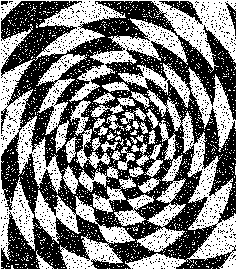

alpha estimé : 0.009816302553194987
beta estimé : 0.2476510983501798
tau estimé : 0.6435832869006353
distance entre images :  7076.633927176122


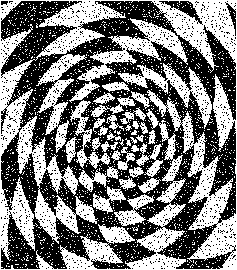

alpha estimé : 0.009820728271930434
beta estimé : 0.27080988486803037
tau estimé : 0.7144227299658467
distance entre images :  7086.098296608845


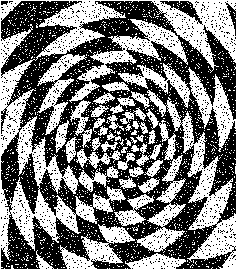

alpha estimé : 0.009812803956870737
beta estimé : 0.29261411297789497
tau estimé : 0.7799742946732046
distance entre images :  7098.447804344429


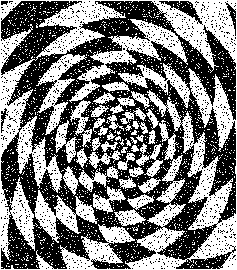

alpha estimé : 0.009807870463819732
beta estimé : 0.31360983952134824
tau estimé : 0.8391959932432287
distance entre images :  6623.332473824035


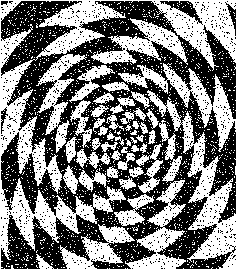

alpha estimé : 0.009789873226395995
beta estimé : 0.33392886424142676
tau estimé : 0.8919823595822819
distance entre images :  5165.468901390842


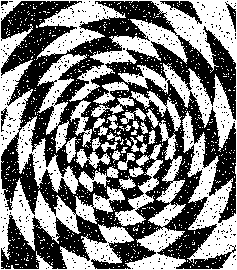

alpha estimé : 0.00978415600023085
beta estimé : 0.3534522776228574
tau estimé : 0.938986590532677
distance entre images :  3872.1538521644006


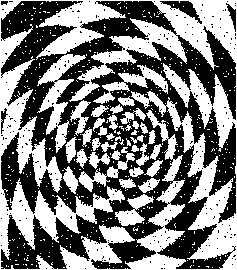

alpha estimé : 0.00977701820871622
beta estimé : 0.3723394451260541
tau estimé : 0.9802414148433675
distance entre images :  3089.8788873261446


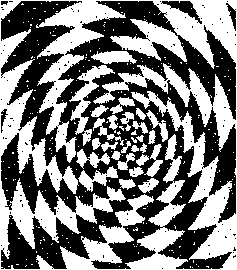

alpha estimé : 0.009780169522084233
beta estimé : 0.3907634937121818
tau estimé : 1.0166529320607065
distance entre images :  2730.204953899047


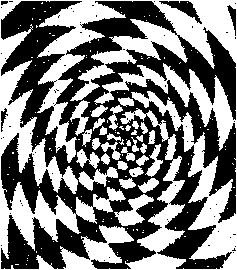

alpha estimé : 0.009776898480678786
beta estimé : 0.40863054620659894
tau estimé : 1.048960998362888
distance entre images :  2634.0629004531957


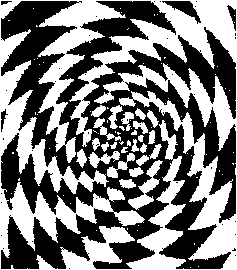

alpha estimé : 0.009771157082614619
beta estimé : 0.42583847393738056
tau estimé : 1.0774254089430735
distance entre images :  2686.808329426473


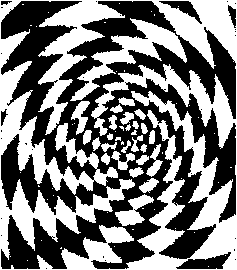

alpha estimé : 0.009751997153134377
beta estimé : 0.44267108917005327
tau estimé : 1.1026318292773778
distance entre images :  2829.439365525863


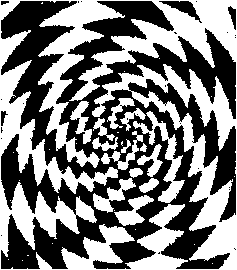

alpha estimé : 0.009737588465487775
beta estimé : 0.459023482201158
tau estimé : 1.1249501396593846
distance entre images :  3195.5450851695578


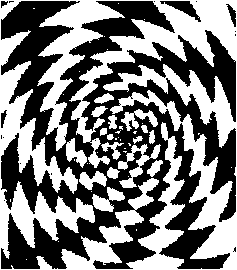

alpha estimé : 0.009743645265950753
beta estimé : 0.47496712251340195
tau estimé : 1.1447558949261076
distance entre images :  3617.0343022347242


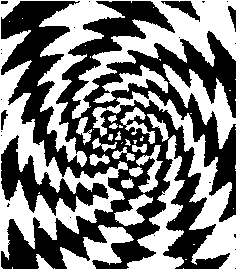

alpha estimé : 0.009731152370712872
beta estimé : 0.4905634804357739
tau estimé : 1.1623292326240124
distance entre images :  4416.042272230036


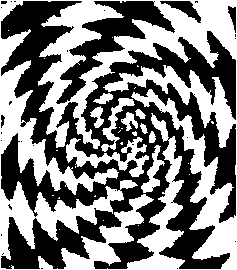

alpha estimé : 0.009711661700350123
beta estimé : 0.5057518823836169
tau estimé : 1.1777622445987994
distance entre images :  5538.974761681513


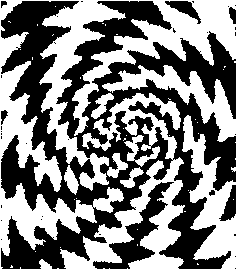

alpha estimé : 0.00970353223302224
beta estimé : 0.5205406548971139
tau estimé : 1.1911906815429236
distance entre images :  6665.346304110018


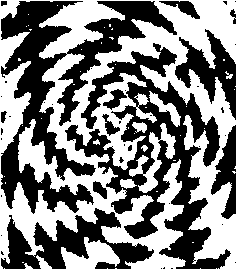

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in exp


alpha estimé : 0.009689227598443673
beta estimé : 0.5351348486433344
tau estimé : 1.2024405392579547
distance entre images :  8872.166275980622


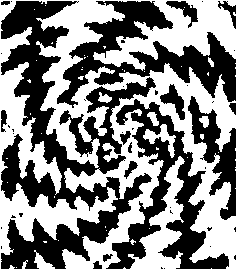

alpha estimé : 0.009676884427784587
beta estimé : 0.5492257790779951
tau estimé : 1.2121568213203269
distance entre images :  10976.520003125488


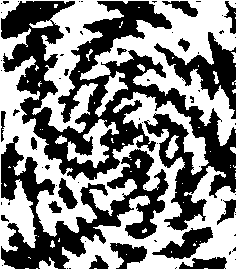

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


alpha estimé : 0.00968000472554374
beta estimé : 0.5631739204711175
tau estimé : 1.2203616063086342
distance entre images :  13373.109548366932


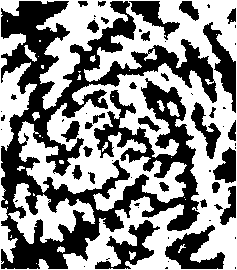

KeyboardInterrupt: ignored

In [21]:
def debruiteur_Q3(img_bruitee, gamma_inv, rho_inv, theta_exp, sigma_rayleigh, nbre_tirages):
  img_random = 2*np.random.randint(2, size=(height, length))-1
  a,b = img_random.shape
  sim_tau = [0.5*np.ones((height, length)) for i in range(nbre_tirages)]
  sim_alpha = [0.01*np.ones((height, length)) for i in range(nbre_tirages)]
  sim_beta = [0.2*np.ones((height, length)) for i in range(nbre_tirages)]
  somme_voisins = 0
  samplez = 20
  probas = np.zeros((height, length))
  for step in range(1, nbre_tirages):
    mean_alpha=np.mean(sim_alpha[step-1])
    mean_beta=np.mean(sim_beta[step-1])
    mean_tau=np.mean(sim_tau[step-1])
    sum_alpha, sum_beta, sum_tau = np.zeros((height, length)), np.zeros((height, length)), np.zeros((height, length))
    for s in range(samplez):
      sampled_alpha_copy, sampled_beta_copy, sampled_tau_copy = np.zeros((height, length)), np.zeros((height, length)), np.zeros((height, length))
      for k in range(1, img_random.shape[0]-1):
        for l in range(1, img_random.shape[1]-1):
          y = sample_y_Q3(k, l, img_random, img_bruitee, mean_alpha, mean_beta, mean_tau)
          img_random[k, l] = y
          if y == 1:
            probas[k,l] += 1
          markov_blanket = [img_random[k - 1, l], img_random[k, l - 1], img_random[k, l + 1], img_random[k + 1, l], img_bruitee[k, l]]
          somme_voisins = 0
          for g in range(len(markov_blanket)):
            if (img_random[k,l] == markov_blanket[g]):
              somme_voisins+=1
          densite_sampling_A = lambda A: np.exp(A*img_random[k,l] + sim_beta[step-1][k,l]*somme_voisins - 1/(2*sim_tau[step-1][k,l]**2)*(img_random[k,l] - img_bruitee[k,l])**2 - abs(A)/theta_exp)
          sampled_alpha_copy[k, l] = metropolis_hastings(densite_sampling_A, a, b, sim_alpha[step-1][k,l], std_choice = 0.01, size=1)
          sim_alpha[step][k, l] = sampled_alpha_copy[k, l]
          densite_sampling_B = lambda B: np.exp(sim_alpha[step][k,l]*img_random[k,l] + B*somme_voisins - (-1/(2*sim_tau[step-1][k,l]**2)*(img_random[k,l] - img_bruitee[k,l])**2) - B**2/(2*sigma_rayleigh**2))*B
          sampled_beta_copy[k, l] = metropolis_hastings(densite_sampling_B, a, b, sim_beta[step-1][k,l], std_choice = 0.1, size=1)
          sim_beta[step][k, l] = sampled_beta_copy[k, l]
          densite_sampling_tau = lambda tau: 1/(tau**(gamma_inv+2))*np.exp(-1/(2*tau**2)*((img_random[k,l] - img_bruitee[k,l])**2) + sim_beta[step][k,l]*somme_voisins + sim_alpha[step][k,l]*img_random[k,l] - rho_inv/tau)
          sampled_tau_copy[k, l] = metropolis_hastings(densite_sampling_tau, a, b, sim_tau[step-1][k, l], std_choice=0.2, size=1)
          sim_tau[step][k, l] = sampled_tau_copy[k, l]
      sum_alpha += sampled_alpha_copy
      sum_beta += sampled_beta_copy
      sum_tau += sampled_tau_copy
    img_random = 2*(probas/samplez <= 0.5) - 1 # Matrice des y déterminés par Gibbs
    probas = np.zeros((height, length)) # Reset de la matrice probas (sinon l'image disparaît petit à petit)
    sim_alpha[step] = sum_alpha*np.ones((height, length))/samplez
    sim_beta[step] = sum_beta*np.ones((height, length))/samplez
    sim_tau[step] = sum_tau*np.ones((height, length))/samplez
    print("alpha estimé :", np.mean(sim_alpha[step]))
    print("beta estimé :", np.mean(sim_beta[step]))
    print("tau estimé :", np.mean(sim_tau[step]))
    img_random[img_random == 1] = 255
    img_random[img_random == -1] = 0
    img_random = np.array(img_random, dtype=np.int64) # image débruitée après l'étape step
    print("Erreur : ", measureError.qualityError(imag_random, data, neighbourThreshold = 3)) # affiche la distance entre l'image débruitée générée et l'image originale
    PIL_image2 = Image.fromarray(np.uint8(img_random)).convert('L')
    display(PIL_image2)
    img_random = 2*np.random.randint(2, size=(height, length)) - 1
  return sim_tau, sim_beta, sim_alpha

debruiteur_Q3(bruit_test_norm, alpha_ising, beta_ising, gamma_inv, rho_inv, 100)

## 4 Algorithme ABC pour la loi jointe de tous les paramètres

On met en oeuvre un algorithme de type ABC poru simuler la loi jointe de tous les paramètres et des $x_i$, sans contrainte sur la loi à priori de $(\alpha, \beta)$

0.7489550245769359
0.7685301903830092
0.780172268690433
0.7206358565387815
0.6899138381150548
0.7597381591006119
0.7813260190886812
0.6136731437777279
0.5362263965332335
0.7189058265833147
0.7730493943318995
0.7011354119579536
0.7277171298536372
0.807823732053221
0.7137061621611608
0.7856865308428183
0.733505055359185
0.6203660045783441
0.8364160352144604
0.7018461700249377
0.7748047193298968
0.7428042993356024
0.7626603926591163
0.7830825701146551
0.7960001411112381
0.7415091684107494
0.7789077989587959
0.6900897610773206
0.7679971756474976
0.6977045637499357
0.6983922805866143
0.6616209618465169
0.5597027473635966
0.6808626442245206
0.5875399411025805
0.7491255242349171
0.7981292196753061
0.7092275440529043
0.7549854673237479
0.6684316054820144
0.7534032510034531
0.8077637440209263
0.7074217261568783
0.7085384322631093
1.018551036262656
0.7321015142859505
0.6815622978831644
0.7143524269503182
0.760938792293175
0.6775426087600875
0.8408365017679712
0.7201215353335229
0.771555327729502

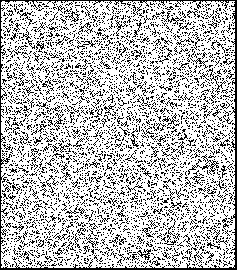

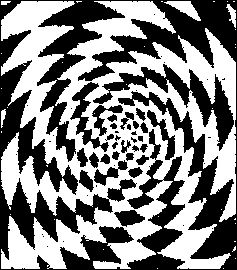

In [51]:
# https://towardsdatascience.com/the-abcs-of-approximate-bayesian-computation-bfe11b8ca341

echantillon = np.array(ImageOps.grayscale(Image.open('op-art-black-and-white-infinity-whirl-tom-hill.jpg')))
echantillon = 2*(echantillon/255) - 1
np.array(echantillon)
def mise_en_forme(echantillon, alpha, beta, tau):
  echantillon = np.array(echantillon)
  ech_vide = [[(0, 0, 0, 0) for j in range(echantillon.shape[1])] for i in range(echantillon.shape[0])]
  for i in range(echantillon.shape[0]):
    for j in range(echantillon.shape[1]):
      ech_vide[i][j] = (echantillon[i][j], alpha, beta, tau)
  return np.array(ech_vide)

echantillon = mise_en_forme(echantillon, 0, 0.3, 1.18)

#Fonction de sampling d'une loi d'Ising
def sample_x(i, j, Y, X, alpha, beta):
  markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], Y[i, j]]
  prob = np.exp(alpha*markov_blanket[-1] + beta*np.sum(markov_blanket[:3]))/np.exp(alpha + 4*beta)
  return (np.random.rand() < prob) * 2 - 1

#Distance function - Absolute difference 
def distance_function(X,Y):
    Y = Y[1:height-1, 1:length-1]
    distance = np.mean(np.square((X - Y)))
    return distance

#The ABC method with uniform prior, returns samples from the posterior
def ABC_Method_Uniform_Prior(Observed_data,Number_of_Samples,threshold):
    #The observed data 
    #initialise Posterior array
    Posterior_distribution = []
    #trials
    #loop through to get the samples. 
    for i in range(0,Number_of_Samples):
        distance = threshold+1
        #While the distance is greater than the threshold continue to sample theta from the beta distribution
        while distance > threshold:
            #sample theta from the prior
            img_random = 2*np.random.randint(2, size=(height, length))-1
            alpha_sample = np.random.laplace(0, 0.01)
            beta_sample = np.random.rayleigh(0.4)
            tau_sample = 1/np.random.gamma(3, 2)
            x_sample = [[sample_x(i, j, img_random, bruit_test_norm, alpha_sample, beta_sample) for j in range(1, echantillon.shape[1]-1)] for i in range(1, echantillon.shape[0]-1)]
            theta = mise_en_forme(x_sample, alpha_sample, beta_sample, tau_sample)
            # calcalute the distance from Y 
            distance = distance_function(theta,Observed_data)
            print(distance)
        Posterior_distribution.append(theta)
    return Posterior_distribution

result = ABC_Method_Uniform_Prior(echantillon,1,0.5)
print("alpha : {}, beta : {}, tau : {}".format(result[0][0][0][1], result[0][0][0][2], result[0][0][0][3]))

# On récupère l'image directement donnée par l'algorithme ABC
img_ABC = np.zeros((height,length))
for i in range(1, height-2):
  for j in range(1, length-2):
    img_ABC[i,j] = result[0][i][j][0]
img_ABC_display = Image.fromarray(np.uint8(img_ABC)).convert('L')
display(img_ABC_display)

# On récupère l'image donnée par les paramètres tau, alpha et beta estimés par ABC
probas_Q1 = debruiteur(bruit_test_norm, 20, result[0][0][0][1], result[0][0][0][2], result[0][0][0][3])
probas_Q1[probas_Q1 > 0.5] = 255
probas_Q1[probas_Q1 <= 0.5] = 0
PIL_image3 = Image.fromarray(np.uint8(probas_Q1)).convert('L')
display(PIL_image3)